# CLIP + SAM

In [1]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import torch
import numpy as np

In [2]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"))

In [3]:
image_path = "/kaggle/input/exemplefruit/exemple.PNG"

In [4]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [5]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sj8rm5qq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sj8rm5qq
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=3bb95291d98724207f15a4629ee22548b2b5560200e1976b2b38fb74adce963f
  Stored in directory: /tmp/pip-ephem-wheel-cache-tt2lwpjy/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [6]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 2.0.0


In [7]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [8]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [9]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [10]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [11]:
cropped_boxes

[<PIL.Image.Image image mode=RGB size=224x139>,
 <PIL.Image.Image image mode=RGB size=162x134>,
 <PIL.Image.Image image mode=RGB size=563x471>,
 <PIL.Image.Image image mode=RGB size=57x46>,
 <PIL.Image.Image image mode=RGB size=46x45>,
 <PIL.Image.Image image mode=RGB size=92x116>,
 <PIL.Image.Image image mode=RGB size=89x89>,
 <PIL.Image.Image image mode=RGB size=111x83>,
 <PIL.Image.Image image mode=RGB size=87x85>,
 <PIL.Image.Image image mode=RGB size=180x103>,
 <PIL.Image.Image image mode=RGB size=79x103>,
 <PIL.Image.Image image mode=RGB size=63x63>,
 <PIL.Image.Image image mode=RGB size=92x86>,
 <PIL.Image.Image image mode=RGB size=48x41>,
 <PIL.Image.Image image mode=RGB size=45x52>,
 <PIL.Image.Image image mode=RGB size=157x176>,
 <PIL.Image.Image image mode=RGB size=75x76>,
 <PIL.Image.Image image mode=RGB size=415x350>,
 <PIL.Image.Image image mode=RGB size=81x73>,
 <PIL.Image.Image image mode=RGB size=81x74>,
 <PIL.Image.Image image mode=RGB size=114x112>,
 <PIL.Image.Image

In [12]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 147MiB/s]


In [13]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [14]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

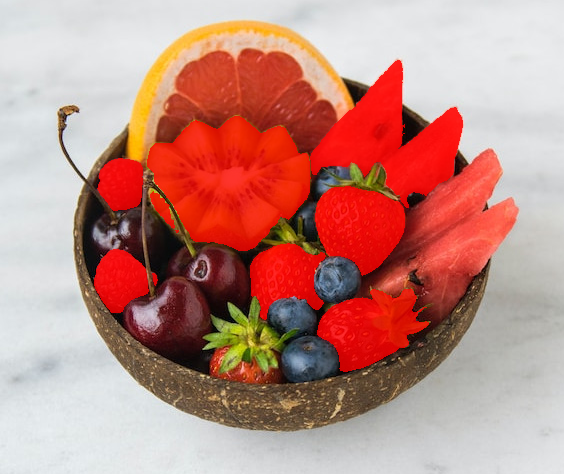

In [19]:
scores = retriev(cropped_boxes, "strawberry")
indices = get_indices_of_values_above_threshold(scores, 0.05)

segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
    segmentation_masks.append(segmentation_mask_image)

original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 200)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image